In [96]:
import mne
import numpy as np
import os.path as op
import csv
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd

First thing we're going to do is read in all the files we'll need:  the evoked `.fif` files and the montage descriptions (in `.sfp` format).

In [2]:
datadir = '/home/chris/Projects/MNE-dev/PCI_instructional/Data'

In [3]:
montage = mne.channels.read_montage(kind='brainampnew', path=datadir)
xdata = np.genfromtxt(op.join(datadir, 'F3_post_X.dat'), delimiter=',')
evoked = mne.Evoked(fname=op.join(datadir,'F3_numpy-ave.fif'))

Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1200.00 ms (No comment)
        0 CTF compensation matrices available
        nave = 1 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.


In [4]:
times = xdata[0,:]/1000.0
evoked.set_montage(montage)
evoked.times = times

Just to remember what evoked is, let's go ahead and plot it.

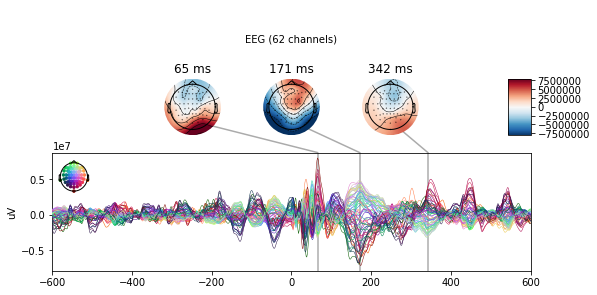

In [5]:
evoked.plot_joint(times='peaks', show=False)

Per Massimini et al., 
 > First, each source's activity was centralized and normalized on the mean and standard deviation of it baseline level (from -500 to -1 ms).  Then, surrogate average baseline activity was obtained for each source by randomly shuffling pre-stimulus samples at the single-trial level (59).  At this point, the maximum absoute value of the surrogates across all sources was calculated (60).  This entire procedure was repeated 500 times to obtain a distribution of 500 bootstraps, corrected for multiple comparisons.  The one-tail ($1-\alpha$) $100^{th}$ percentile of the distribution of the maximum aboslute values was used to estimate a significance threshold $T(\alpha)$ for all normalized sources and samples.

In [14]:
bootstrap_min_time = -0.500
bootstrap_max_time = -0.001
bootstrap_min_index = int(evoked.time_as_index(bootstrap_min_time))
bootstrap_max_index = int(evoked.time_as_index(bootstrap_max_time))

In [18]:
print("We will bootstrap from the baseline of {min}s (at index {min_index}) to {max}s (at index {max_index})".format(min=bootstrap_min_time, max=bootstrap_max_time, min_index=bootstrap_min_index, max_index=bootstrap_max_index))

We will bootstrap from the baseline of -0.5s (at index 62) to -0.001s (at index 374)


Here's a function that will do the bootstrap resampling for us. It takes your array and returns an array of the same size (or a different size, if you specify `n`) comprised of random samples of your array with replacement.

In [22]:
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)   
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

In [53]:
bootstrap_MAVs = np.zeros((evoked.data.shape[0], 500))
print(bootstrap_MAVs.shape)

(62, 500)


## A Brief explanation of the bootstrapping method

* Here we want to create and fill a 2-dimensional array with each row corresponding to an EEG channel, and each column corresponding to the Maximum Absolute Value of one round of bootstrapping that channel.  Like this:

\begin{bmatrix}
    max(|Fp1_{bs1}|)  & max(|Fp1_{bs2}|)  & max(|Fp1_{bs3}|) & \dots & max(|Fp1_{bs500}|) \\
    max(|Fp2_{bs1}|)  & max(|Fp2_{bs2}|)  & max(|Fp2_{bs3}|) & \dots & max(|Fp2_{bs500}|) \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    max(|Oz_{bs1}|)  & max(|Oz_{bs2}|)  & max(|Oz_{bs3}|) & \dots & max(|Oz_{bs500}|)
\end{bmatrix}

Here's an easier way to think about it, with a simple matrix:

In [54]:
data = np.arange(24).reshape(3, 8)
data

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23]])

Let's say we want to bootstrap 5 times, instead of 500.

In [55]:
MAV_bootstrapped_data = np.zeros((data.shape[0], 5))
MAV_bootstrapped_data

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

Each round of bootstrapping we do this:

In [56]:
bootstrapped_data = np.apply_along_axis(bootstrap_resample,
                                       axis=1,
                                       arr=data)
bootstrapped_data

array([[ 0,  2,  5,  7,  2,  6,  6,  2],
       [11, 10, 11, 14, 10, 13, 10, 12],
       [19, 23, 22, 21, 23, 16, 18, 21]])

...and fill one column of the MAV matrix with this:

In [57]:
MAV_bootstrapped_data[:, 0] = np.max(np.abs((bootstrapped_data)), axis=1)
MAV_bootstrapped_data

array([[  7.,   0.,   0.,   0.,   0.],
       [ 14.,   0.,   0.,   0.,   0.],
       [ 23.,   0.,   0.,   0.,   0.]])

In [58]:
for count in range(0,500):
    # Take the points between -0.2s and 0.0s for each source and
    # generate a bootstrap of them
    bs_prestimulus = np.apply_along_axis(bootstrap_resample, 
        axis=1, 
        arr=evoked.data[:, bootstrap_min_index:bootstrap_max_index])
    bootstrap_MAVs[:, count] = np.max(np.abs((bs_prestimulus)), axis=1)

In [61]:
bootstrap_99_percentiles = np.zeros((evoked.data.shape[0], 1))
bootstrap_99_percentiles[:, 0] = \
    np.apply_along_axis(np.percentile, 
                        axis=1, 
                        arr=bootstrap_MAVs, q=99)
post_stim_min_index = int(evoked.time_as_index(0.0))
post_stim_max_index = int(evoked.time_as_index(0.3))
significant_activations = \
    np.abs(evoked.data[:, post_stim_min_index:post_stim_max_index]) > \
        bootstrap_99_percentiles

In [65]:
%matplotlib inline

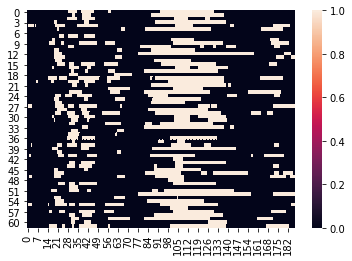

In [66]:
ax = sns.heatmap(significant_activations)

In [68]:
import zlib 
def kolmogorov(s):
    l = float(len(s))
    compr = zlib.compress(s)
    c = float(len(compr))
    return c/l

In [73]:
sig_act_sorted_string = ''.join(significant_activations.astype(int).astype(str).ravel().tolist())
sig_act_rand = ''.join(random.sample(sig_act_sorted_string, len(sig_act_sorted_string)))

In [74]:
kolmogorov(str.encode(sig_act_sorted_string)) / kolmogorov(str.encode(sig_act_rand))

0.3496218731820826

/home/chris/Projects/MNE-2017/mne-venv-py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


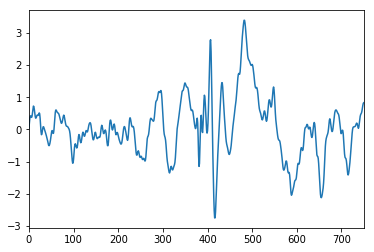

In [77]:
sns.tsplot(evoked.data[0,:])

In [78]:
evoked_df = evoked.to_data_frame()

Converting time column to int64...


In [79]:
evoked_df.head()

signal,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,FT7,FT8,TP7,TP8,PO7,PO8,Fpz,CPz,POz,Oz
time,,,,,,,,,,,,,,,,,,,,,
-600,41999.999434,156660.005450,48964.999616,165810.003877,59112.001210,478020.012379,-806689.977646,646099.984646,-1.370300e+06,5872.999784,...,-238480.001688,257340.013981,-7.620000e+05,788649.976254,-2.096100e+06,591780.006886,111369.997263,436390.012503,-319739.997387,-6.588800e+05
-598,202559.992671,293579.995632,191620.007157,248309.999704,96280.999482,536090.016365,-887880.027294,638040.006161,-1.657100e+06,-100129.999220,...,-185450.002551,262270.003557,-9.570600e+05,672990.024090,-2.411800e+06,509479.999542,264899.998903,471179.991961,-322039.991617,-8.341700e+05
-597,344280.004501,422360.002995,293720.006943,336840.003729,153740.003705,626630.008221,-938539.981842,614250.004292,-1.884600e+06,-255219.995975,...,-138860.002160,296609.997749,-1.126900e+06,546329.975128,-2.607400e+06,323819.994926,403200.000525,512409.985065,-350899.994373,-1.041300e+06
-595,419039.994478,519779.980183,308780.014515,418280.005455,188289.999962,737339.973450,-939409.971237,588110.029697,-1.990900e+06,-382450.014353,...,-157659.992576,370790.004730,-1.216900e+06,459430.009127,-2.633400e+06,111419.998109,490099.996328,540030.002594,-370020.002127,-1.209400e+06
-594,419319.987297,583259.999752,235559.999943,484230.011702,184569.999576,859040.021896,-892960.011959,575580.000877,-1.970900e+06,-427370.011806,...,-258249.998093,480749.994516,-1.238700e+06,431470.006704,-2.514500e+06,-59953.000396,521250.009537,539969.980717,-361589.998007,-1.292100e+06


In [97]:
pd.options.display.mpl_style = 'default'

/home/chris/Projects/MNE-2017/mne-venv-py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


/home/chris/Projects/MNE-2017/mne-venv-py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


/home/chris/Projects/MNE-2017/mne-venv-py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


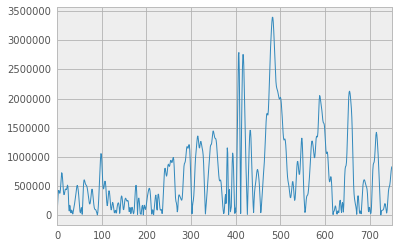

In [98]:
sns.tsplot(np.abs(evoked_df.Fp1))

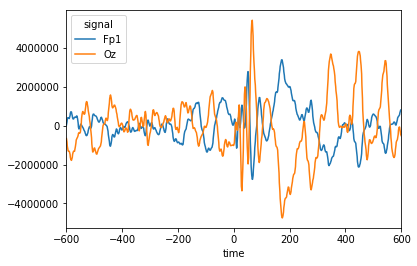

In [95]:
evoked_df.plot(y=['Fp1', 'Oz'])

/home/chris/Projects/MNE-2017/mne-venv-py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


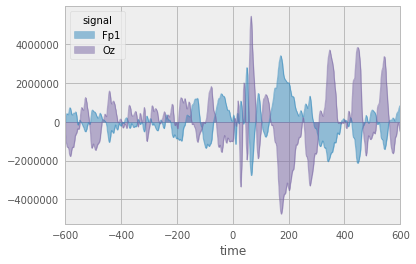

In [99]:
evoked_df.plot(kind='area', stacked=False, y=['Fp1', 'Oz'])